# Proyecto 1

Imanol Muñiz Ramirez A01701713

## Objetivo 1

### 1.a Provide understanding of the candy category by manufacturermarket share composition by year

Primero importamos las librería que vamos a utilizar y hacemos dos dataframes para contener los datos del archivos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Cargar datos
try:
    df_catalog = pd.read_csv('./DATA_CATALOG_2024.csv', encoding='latin1')
    df_sales = pd.read_csv('./DATOS_VENTA_2024.csv')
    print("Archivos de datos cargados exitosamente.")
except FileNotFoundError:
    print("Error: Los archivos 'DATA_CATALOG_2024.csv' o 'DATOS_VENTA_2024.csv' no se encontraron.")
    print("Asegúrate de que estén en la misma carpeta que el script y vuelve a intentarlo.")
    exit()

Archivos de datos cargados exitosamente.


Revisamos que los dataframes se estén obteniendo correctamente.

In [2]:
print("Primeras filas del catálogo:")
print(df_catalog.head())
print("Primeras filas de las ventas:")
print(df_sales.head())

Primeras filas del catálogo:
          ID   FAB                               PRODUCT CATEGORY SUBCATEGORY  \
0  981024284  FAB1                  6PZ CALAVERA       A    OTROS   HALLOWEEN   
1     157612  FAB2             RG 36/30GR MAZAPAN AZTECA    CANDY    REGIONAL   
2      46571  FAB3  PALETA CALABACITA AGRIDULCE 30 PZAS.    SPICY       SPICY   
3     743164  FAB3   DRAGONZITOS 300PZ DRAGONZITOS 300PZ    SPICY       SPICY   
4     225218  FAB3                   MOZTRITOS COLGANTES    SPICY   HALLOWEEN   

      TYPE  
0  SEASONS  
1  REGULAR  
2  REGULAR  
3  REGULAR  
4  SEASONS  
Primeras filas de las ventas:
  CORTE         ID  ANIO  MES       FECHA       VALOR UNIDADES VOLUMEN
0    TN  981005567  2020    1  01/01/2020  $2,026,034   18,396  18,396
1    TN     265754  2020    1  01/01/2020    $622,827    6,346   6,346
2    TN  980017513  2020    1  01/01/2020    $276,840    2,805   2,805
3    TN  981008733  2020    1  01/01/2020  $5,709,468   43,632  43,632
4    TN  980015450  2

Ahora tenemos dos dataframes con los datos. El primero de ellos es un catálogo de los productos que vende cada fabricante. El otro contiene las ventas de cada producto por mes en casi 5 años. Dado que búscamos mostrar entendimiento del mercado de dulces tenemos que generar las tablas que nos permitan visualizar información relevante.

Para comprender la repartición del mercado vamos a generar una tabla con las ventas de cada año por fabricante. De esta forma podrémos apreciar la distribución de ventas, qué fabricantes generan más valor y qué parte del mercado sustentan. 

In [3]:
import pandas as pd

# Limpiar la columna VALOR
df_sales['VALOR'] = (
    df_sales['VALOR']
    .replace(r'[\$,]', '', regex=True)
    .astype(float)
)

# Agregar ventas por ID y año
df_yearly = (
    df_sales
    .groupby(['ID', 'ANIO'], as_index=False)['VALOR']
    .sum()
)

# Pivotear la tabla para tener años como columnas
df_pivot = df_yearly.pivot(index='ID', columns='ANIO', values='VALOR').reset_index()
df_pivot.columns = [str(c) for c in df_pivot.columns]

# Forzar que existan las columnas de 2020 a 2024 aunque falten
for year in ['2020', '2021', '2022', '2023', '2024']:
    if year not in df_pivot.columns:
        df_pivot[year] = 0

# Convertir a numérico por seguridad
df_pivot[['2020', '2021', '2022', '2023', '2024']] = (
    df_pivot[['2020', '2021', '2022', '2023', '2024']]
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0)
)

# Unir con catálogo
df_final = df_catalog.merge(df_pivot, on='ID', how='left').fillna(0)

# Filtrar por la categoría 'CANDY'
df_candy = df_final[df_final['CATEGORY'] == 'CANDY'].copy()

# Agrupar por fabricante y sumar ventas anuales
df_candy_fab = (
    df_candy.groupby('FAB')[['2020', '2021', '2022', '2023', '2024']]
    .sum()
    .reset_index()
)


Decidimos solo tomar aquellos fabricantes que engloben el 80% del mercado con el objetivo de poder visualizar mejor los gráficos y apelando al principio de Pareto que indica para este caso que el 80% de las ventas se estarían generando por el 20% de los fabricantes aproximadamente.

In [4]:
# Filtrar solo CANDY
df_candy = df_final[df_final['CATEGORY'] == 'CANDY'].copy()

# Agrupar por fabricante y sumar ventas
df_candy_fab = (
    df_candy.groupby('FAB')[['2020','2021','2022','2023','2024']]
    .sum()
    .reset_index()
)

# Calcular el total acumulado de cada fabricante en todos los años
df_candy_fab['TOTAL'] = df_candy_fab[['2020','2021','2022','2023','2024']].sum(axis=1)

# Ordenar fabricantes por ventas totales
df_candy_fab = df_candy_fab.sort_values(by='TOTAL', ascending=False)

# Calcular participación porcentual y acumulada
df_candy_fab['SHARE'] = df_candy_fab['TOTAL'] / df_candy_fab['TOTAL'].sum()
df_candy_fab['CUM_SHARE'] = df_candy_fab['SHARE'].cumsum()

# Filtrar solo fabricantes que conforman el 80% del mercado
df_candy_fab_top = df_candy_fab[df_candy_fab['CUM_SHARE'] <= 0.8].copy()

# Lista de fabricantes top 80%
top_fabs = df_candy_fab_top['FAB'].unique()

Gráficos

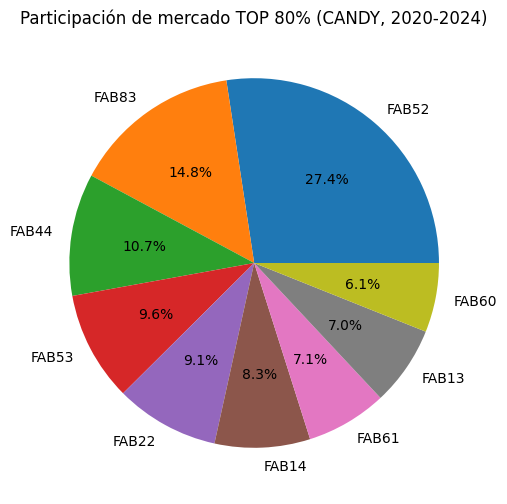

In [5]:
# --- Pie chart con top 80% ---
plt.figure(figsize=(8,6))
plt.pie(df_candy_fab_top['TOTAL'], labels=df_candy_fab_top['FAB'], autopct='%1.1f%%')
plt.title("Participación de mercado TOP 80% (CANDY, 2020-2024)")
plt.show()

Podemos apreciar como tan solo 9 de los 87 facbricantes tienen el 80% del mercado de dulces, siendo FAB52 y FAB83 los que se tienen mayor parte.

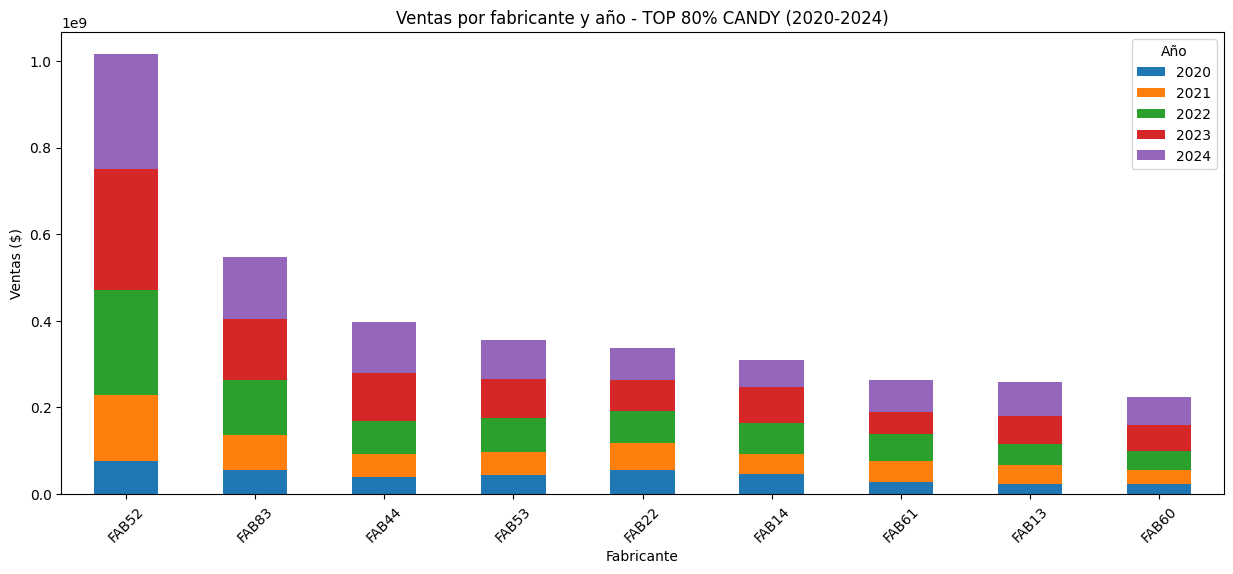

In [6]:
# --- Barras stacked por año solo top 80% ---
fig, ax = plt.subplots(figsize=(15,6))
df_candy_fab_top.set_index('FAB')[['2020','2021','2022','2023','2024']].plot(
    kind='bar', stacked=True, ax=ax
)

ax.set_title("Ventas por fabricante y año - TOP 80% CANDY (2020-2024)")
ax.set_xlabel("Fabricante")
ax.set_ylabel("Ventas ($)")
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.show()

df_candy_fab_top.to_csv('./CANDY_MARKET_SHARE.csv', index=False)

Para el año 2022, FAB52 ya vendía lo las demás FABs en el año 2024. FAB83 en el año 2023 vendía lo que las demás en el año 2024. También es interesante notar como todos los fabricantes iniciaron con un valor de ventas similar en el primer año, sin duda sería interesante analizar las estrategias utilizadas por los fabricantes que más detacaron para desmarcarse de la competencia.

### 1.b Provide understanding of the candy category by manufacturer sales and price performance over time.

Para este punto vamos a generar distintos gráficos para observar el cómo los cambios en los precios de los dulces han provocado cambios en el volumen de ventas y en el valor generado por cada fabricante. Para esto primero creamos una nueva tabla que contenga el precio promedio de todos los productos de cada fabricante.

Primero filtramos y obtenemos los datos que necesitamos visualizar.

In [7]:
# --- Partimos de df_sales (todas las ventas) y df_catalog ---
# Filtrar solo CANDY
df_catalog_candy = df_catalog[df_catalog['CATEGORY'] == 'CANDY']

# Merge para quedarnos con info de FAB en las ventas
df_candy_sales = df_sales.merge(df_catalog_candy[['ID','FAB']], on='ID', how='inner')

# --- Limpieza de UNIDADES ---
df_candy_sales['UNIDADES'] = (
    df_candy_sales['UNIDADES']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# --- Agrupar por FAB y ANIO ---
df_candy_perf = (
    df_candy_sales
    .groupby(['FAB','ANIO'], as_index=False)
    .agg({'VALOR':'sum','UNIDADES':'sum'})
)
df_candy_perf_top = df_candy_perf[df_candy_perf['FAB'].isin(top_fabs)]

# --- Calcular precio promedio ---
df_candy_perf_top['PRECIO_PROM'] = df_candy_perf_top['VALOR'] / df_candy_perf_top['UNIDADES']

df_candy_perf_top.to_csv('./CANDY_SALES_PERF.csv', index=False)

C:\Users\Imanol\AppData\Local\Temp\ipykernel_9860\4196741909.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_candy_perf_top['PRECIO_PROM'] = df_candy_perf_top['VALOR'] / df_candy_perf_top['UNIDADES']


Y luego mostramos los gráficos

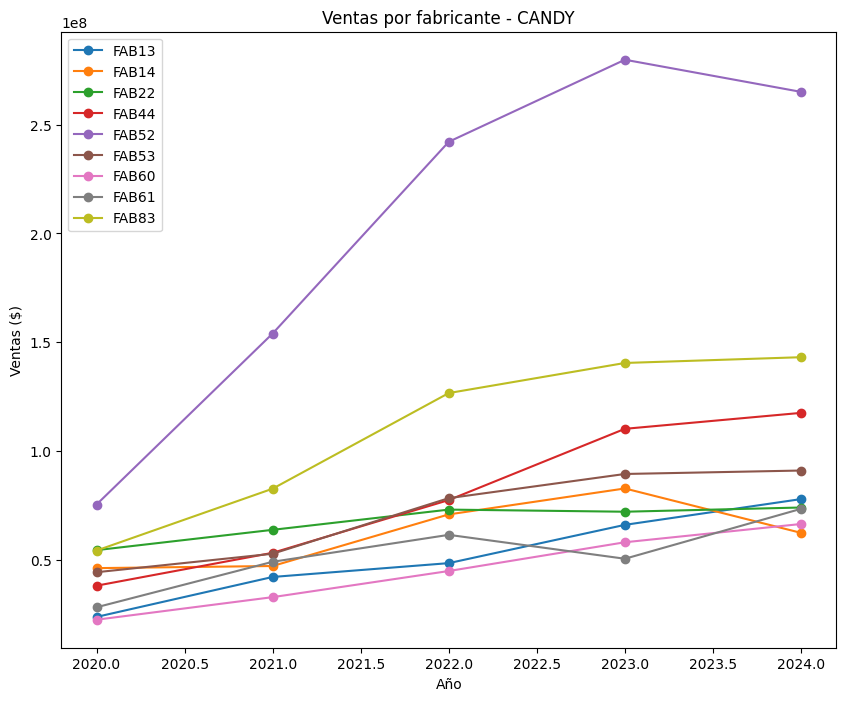

In [8]:
# Gráfico de líneas: ventas por año por fabricante
plt.figure(figsize=(10,8))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.plot(subset['ANIO'], subset['VALOR'], marker='o', label=fab)

plt.title("Ventas por fabricante - CANDY")
plt.xlabel("Año")
plt.ylabel("Ventas ($)")
plt.legend()
plt.show()

Aquí podemos observar el desempeño de cada facbricante al pasar de los años. Aunque todos han crecido, hubo periodos dónde algunos ganaron menos que en años pasados. Por otra parte FAB52 en los 3 primeros años realizó algunas acciones que dispararon su crecimeinto.

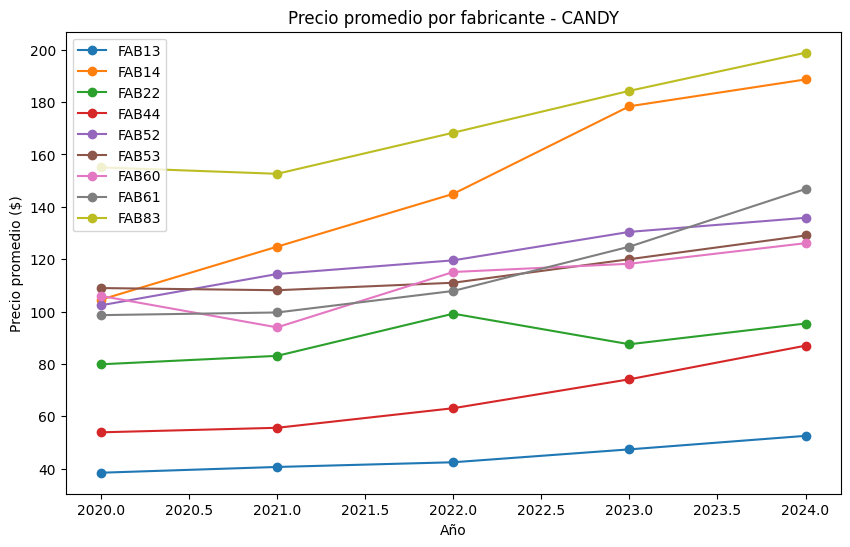

In [9]:
# Gráfico de líneas: precio promedio por año por fabricante
plt.figure(figsize=(10,6))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.plot(subset['ANIO'], subset['PRECIO_PROM'], marker='o', label=fab)

plt.title("Precio promedio por fabricante - CANDY")
plt.xlabel("Año")
plt.ylabel("Precio promedio ($)")
plt.legend()
plt.show()

En este gráfico apreciamos el cambio del precio promedio de los productos de cada fabricante. En la mayoría de los casos no se observa una fuerte relación entre como al incrementar o disminuir el precio de los productos repercute en el valor generado, pues por ejemplo el fabricante de color naranja tuvo dos periodos de incremento en sus precios de la misma proporción y en el gráfico de ventas vemos que en los periodos correspondientes bajó y luego subió. En estos casos podemos concluir que el incremento o disminución del valor generado se debió a otros factores cómo la manufacturación de dulces más costos, pero de mayor calidad y por ello podría deberse la disminución de ventas el primer año, pero el incremento en el segundo.

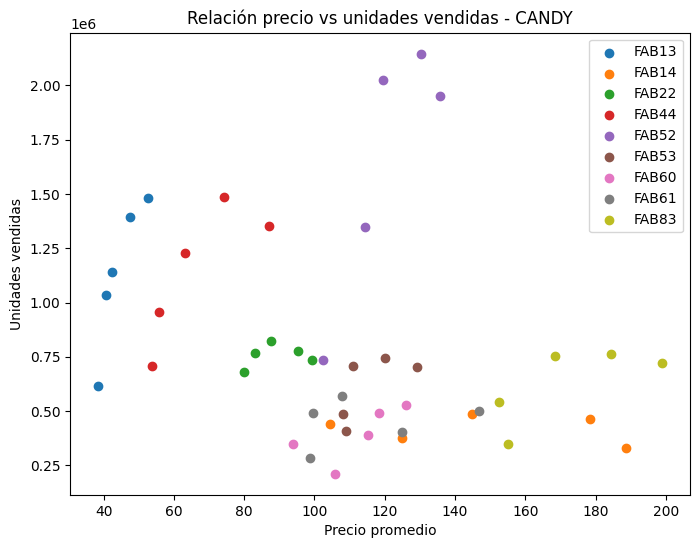

In [10]:
# Gráfico de dispersión: precio promedio vs unidades vendidas
plt.figure(figsize=(8,6))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.scatter(subset['PRECIO_PROM'], subset['UNIDADES'], label=fab)

plt.title("Relación precio vs unidades vendidas - CANDY")
plt.xlabel("Precio promedio")
plt.ylabel("Unidades vendidas")
plt.legend()
plt.show()

Por otra parte también podemos ver en este gráfico cómo el incremento o disminución del precio promedio repercute en el volumen de ventas. Aquí podemos apreciar claramente el precio promedio que generalmente favorece a cada fabricante para obtener un mayor número de ventas.

Finalmente hacemos una tabla con los datos de la evolución del valor, las unidades y el precio promedio por cada año de cada fabricante. 

In [16]:
df_resumen = df_candy_perf_top.pivot(index='FAB', columns='ANIO', values=['VALOR','UNIDADES','PRECIO_PROM'])
df_resumen.columns = [f'{metric}_{year}' for metric, year in df_resumen.columns]
df_resumen = df_resumen.reset_index()
df_resumen['VALOR'] = df_resumen[[f'VALOR_{year}' for year in range(2020,2025)]].sum(axis=1)
df_resumen['UNIDADES'] = df_resumen[[f'UNIDADES_{year}' for year in range(2020,2025)]].sum(axis=1)
df_resumen['PRECIO_PROM'] = df_resumen['VALOR'] / df_resumen['UNIDADES']
df_resumen['INC_VALOR_2021_%'] = (df_resumen['VALOR_2021'] - df_resumen['VALOR_2020']) / df_resumen['VALOR_2020'].replace(0, np.nan) * 100
df_resumen['INC_VALOR_2022_%'] = (df_resumen['VALOR_2022'] - df_resumen['VALOR_2021']) / df_resumen['VALOR_2021'].replace(0, np.nan) * 100
df_resumen['INC_VALOR_2023_%'] = (df_resumen['VALOR_2023'] - df_resumen['VALOR_2022']) / df_resumen['VALOR_2022'].replace(0, np.nan) * 100
df_resumen['INC_VALOR_2024_%'] = (df_resumen['VALOR_2024'] - df_resumen['VALOR_2023']) / df_resumen['VALOR_2023'].replace(0, np.nan) * 100
df_resumen['INC_UNIDADES_2021_%'] = (df_resumen['UNIDADES_2021'] - df_resumen['UNIDADES_2020']) / df_resumen['UNIDADES_2020'].replace(0, np.nan) * 100
df_resumen['INC_UNIDADES_2022_%'] = (df_resumen['UNIDADES_2022'] - df_resumen['UNIDADES_2021']) / df_resumen['UNIDADES_2021'].replace(0, np.nan) * 100
df_resumen['INC_UNIDADES_2023_%'] = (df_resumen['UNIDADES_2023'] - df_resumen['UNIDADES_2022']) / df_resumen['UNIDADES_2022'].replace(0, np.nan) * 100
df_resumen['INC_UNIDADES_2024_%'] = (df_resumen['UNIDADES_2024'] - df_resumen['UNIDADES_2023']) / df_resumen['UNIDADES_2023'].replace(0, np.nan) * 100
df_resumen['INC_PRECIO_PROM_2021_%'] = (df_resumen['PRECIO_PROM_2021'] - df_resumen['PRECIO_PROM_2020']) / df_resumen['PRECIO_PROM_2020'].replace(0, np.nan) * 100
df_resumen['INC_PRECIO_PROM_2022_%'] = (df_resumen['PRECIO_PROM_2022'] - df_resumen['PRECIO_PROM_2021']) / df_resumen['PRECIO_PROM_2021'].replace(0, np.nan) * 100
df_resumen['INC_PRECIO_PROM_2023_%'] = (df_resumen['PRECIO_PROM_2023'] - df_resumen['PRECIO_PROM_2022']) / df_resumen['PRECIO_PROM_2022'].replace(0, np.nan) * 100
df_resumen['INC_PRECIO_PROM_2024_%'] = (df_resumen['PRECIO_PROM_2024'] - df_resumen['PRECIO_PROM_2023']) / df_resumen['PRECIO_PROM_2023'].replace(0, np.nan) * 100
df_resumen = df_resumen.drop(columns=[col for col in df_resumen.columns if col.startswith('VALOR_') or col.startswith('UNIDADES_') or col.startswith('PRECIO_PROM_')])
df_resumen = df_resumen.sort_values(by='VALOR', ascending=False)
df_resumen

,FAB,VALOR,UNIDADES,PRECIO_PROM,INC_VALOR_2021_%,INC_VALOR_2022_%,INC_VALOR_2023_%,INC_VALOR_2024_%,INC_UNIDADES_2021_%,INC_UNIDADES_2022_%,INC_UNIDADES_2023_%,INC_UNIDADES_2024_%,INC_PRECIO_PROM_2021_%,INC_PRECIO_PROM_2022_%,INC_PRECIO_PROM_2023_%,INC_PRECIO_PROM_2024_%
4,FAB52,1.016349e+09,8204432.0,123.878095,104.249252,57.223403,15.576974,-5.281230,82.905141,50.351865,5.948993,-9.030326,11.669497,4.570305,9.087374,4.121259
8,FAB83,5.471185e+08,3125434.0,175.053596,52.409736,53.160492,10.918721,1.885622,54.865850,38.871137,1.298979,-5.572695,-1.585963,10.289651,9.496386,7.898475
3,FAB44,3.964739e+08,5728954.0,69.205282,39.671328,45.559281,42.270231,6.650304,35.337490,28.298332,21.071594,-9.093931,3.202245,13.453760,17.509175,17.319234
5,FAB53,3.558743e+08,3050638.0,116.655695,19.187054,48.383944,14.188421,1.769353,20.101675,44.560590,5.630262,-5.371485,-0.761539,2.644811,8.101995,7.546180
2,FAB22,3.374018e+08,3785214.0,89.136779,17.157171,14.579026,-1.336726,2.690744,12.611837,-4.030055,11.831371,-5.826518,4.036285,19.390530,-11.774958,9.044225
1,FAB14,3.093450e+08,2102846.0,147.107800,2.106503,50.299683,16.828782,-24.648503,-14.452506,29.387117,-5.076625,-28.739811,19.356509,16.162789,23.076937,5.741366
7,FAB61,2.626328e+08,2252546.0,116.593761,74.207852,25.231568,-17.871957,45.444152,72.433664,15.682281,-28.998724,23.619478,1.028910,8.254753,15.671221,17.654721
0,FAB13,2.582842e+08,5672563.0,45.532186,77.344697,15.095863,36.293639,17.926359,67.739543,10.226432,22.125993,6.334952,5.726231,4.417661,11.600845,10.900844
6,FAB60,2.246592e+08,1968782.0,114.110779,46.193082,36.581441,29.457229,14.460092,64.867326,11.490329,26.007998,7.333976,-11.326831,22.505192,2.737311,6.639199


De esta tabla podemos hacer aserveraciones más precisas sobre los fabricantes y en caso de ser necesario hacer un análisis más profundo sobre cómo repercute el cambio de los precios en la generación de valor y venta de unidades (elasticidad). Por ejemplo, en el caso del fabricante con mayor ventas (FAB52) podemos observar que a lo largo de los años ha ido aumentando el precio de sus productos a un porcentaje menor que la mayoría de la competencia, sin embargo el porcentaje de incremento del volumen de unidades y valor generado no se ha mantenido incluso llegando a vender menos unidades y menos valor que en años anteriores. 

## Objetivo 2

### Design and run regression model(s) to estimate price sensitivity (direct price elasticity) by manufacturer (by fabs, not by product).

Con el propósito de ver la elasticidad directa que tienen los fabricantes con el cambio de precios de sus productos o con la estacionalidad, diseñaremos un flujo de trabajo que nos ayudará a comprender los datos y el procedimiento.

Primero del dataframe que contiene los datos de DATA_CATALOG_2024.csv obtenemos los IDs de los productos que vende un fabricante. En este caso vamos a usar de ejemplo al FAB52, pero ajustando el bloque de código siguiente podemos hacerlo para cualquiera. 

In [66]:
# Obtener los IDs de productos de la subcategoría 'CANDY' y fabricante 'FAB52'
ids_candy_fab52 = df_catalog[(df_catalog['CATEGORY'] == 'CANDY') & (df_catalog['FAB'] == 'FAB52')]['ID'].unique()
print(ids_candy_fab52)

[980005631 980012759 980015334 981008733 981014481 980032203 981028364]


Una vez que obtuvimos los IDs de los productos, utilizamos el dataframe que contiene los datos del archivo DATOS_VENTA_2024.csv para encontrar las ventas de cada uno de sus productos. Hacemos unas transformaciones adicionales para finalmente obtener las ventas totales de cada mes (sin diferencias los productos). 

In [67]:
# Lista de IDs que quieres filtrar
ids_filtrar = ids_candy_fab52

# Filtrar las instancias con esos IDs
df_filtrado = df_sales[df_sales['ID'].isin(ids_filtrar)].copy()

# Eliminar columnas CORTE, FECHA y VOLUMEN
df_filtrado = df_filtrado.drop(columns=['CORTE', 'FECHA', 'VOLUMEN'])

# Convertir VALOR a flotante y UNIDADES a entero
df_filtrado['VALOR'] = df_filtrado['VALOR'].replace(r'[^\d.]', '', regex=True).astype(float)
df_filtrado['UNIDADES'] = df_filtrado['UNIDADES'].astype(str).str.replace(',', '', regex=False).astype(int)

# Sumar VALOR y UNIDADES por MES y ANIO para los IDs filtrados
df_filtrado_grouped = (
    df_filtrado
    .groupby(['ANIO', 'MES'], as_index=False)[['VALOR', 'UNIDADES']]
    .sum()
)

print(df_filtrado_grouped)

    ANIO  MES       VALOR  UNIDADES
0   2020    1   6809719.0     60833
1   2020    2   6163122.0     58792
2   2020    3   4066537.0     39028
3   2020    4   4733126.0     54318
4   2020    5   3397684.0     34291
5   2020    6   3895121.0     43209
6   2020    7   3667310.0     34941
7   2020    8   3276144.0     32949
8   2020    9   4364859.0     41960
9   2020   10  10672907.0    105728
10  2020   11   8911504.0     83794
11  2020   12  15434624.0    146431
12  2021    1   8088700.0     71398
13  2021    2   6565472.0     58215
14  2021    3   7031366.0     67241
15  2021    4  14329709.0    145332
16  2021    5   9449702.0     85940
17  2021    6   6854461.0     60492
18  2021    7   8280403.0     71528
19  2021    8   7737197.0     65318
20  2021    9   9415194.0     79564
21  2021   10  19144751.0    176582
22  2021   11  13820365.0    120103
23  2021   12  43271618.0    344970
24  2022    1  12756007.0    109319
25  2022    2  13658078.0    119253
26  2022    3  14260975.0   

Con los datos listos podemos empezar a generar los gráficos que ilustren la elasticidad de los fabricantes. Para este caso, podemos ver que cada año el fabricante 52 en los meses de abril, octubre y diciembre tiende a vender más, por lo que podemos ir viendo una elasticidad estacionaria. 

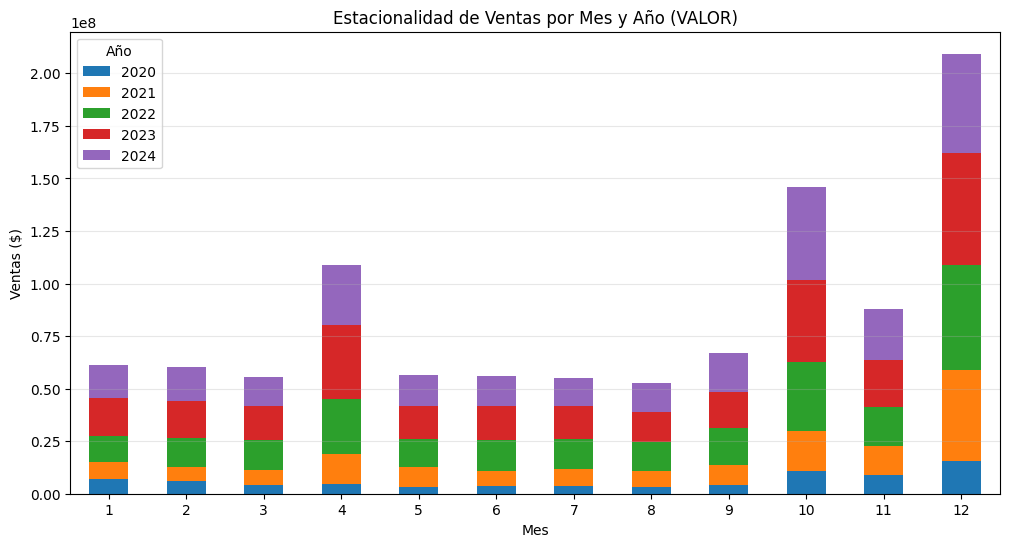

In [68]:
# Pivotear para tener años como columnas y meses como índice
df_pivot = df_filtrado_grouped.pivot(index='MES', columns='ANIO', values='VALOR').fillna(0)

# Crear gráfico de barras apiladas
df_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Estacionalidad de Ventas por Mes y Año (VALOR)')
plt.xlabel('Mes')
plt.ylabel('Ventas ($)')
plt.legend(title='Año')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

De igual forma podemos generar un tabla que nos ayude a ver los incrementos porcentuales de cada mes respecto al anterior o de cada año. Podemos corroborar que en esos meses las ventas tienen un incremento bastante notorio.

In [69]:
# DataFrame con el porcentaje de crecimiento/decrecimiento mensual y anual de ventas

# Porcentaje de cambio mensual por año
df_filtrado_grouped['VALOR_PCT_MES'] = (
    df_filtrado_grouped
    .sort_values(['ANIO', 'MES'])
    .groupby('ANIO')['VALOR']
    .pct_change() * 100
)

# Porcentaje de cambio anual por mes (opcional, si quieres comparar el mismo mes entre años)
df_filtrado_grouped['VALOR_PCT_ANIO'] = (
    df_filtrado_grouped
    .sort_values(['MES', 'ANIO'])
    .groupby('MES')['VALOR']
    .pct_change() * 100
)

# Puedes mostrar el resultado así:
df_filtrado_grouped[['ANIO', 'MES', 'VALOR', 'VALOR_PCT_MES', 'VALOR_PCT_ANIO']]

,ANIO,MES,VALOR,VALOR_PCT_MES,VALOR_PCT_ANIO
0,2020,1,6809719.0,NaN,NaN
1,2020,2,6163122.0,-9.495208,NaN
2,2020,3,4066537.0,-34.018230,NaN
3,2020,4,4733126.0,16.392055,NaN
4,2020,5,3397684.0,-28.214799,NaN
5,2020,6,3895121.0,14.640473,NaN
6,2020,7,3667310.0,-5.848624,NaN
7,2020,8,3276144.0,-10.666292,NaN
8,2020,9,4364859.0,33.231598,NaN
9,2020,10,10672907.0,144.518941,NaN


Sin embargo, para poder hacer aseveraciones más precisas requerimos de un modelo que nos arroje datos concretos. Para esto vamos a utilizar una transformación logaritmica para poner los datos en la forma que requiere el modelo de mínimos cuadrados ordinarios OLS.

In [85]:
# Solución al error: asegurar que X y y sean numéricos (float)

import numpy as np
import statsmodels.api as sm

df_estacional = df_filtrado_grouped.copy()
df_estacional = df_estacional[(df_estacional['VALOR'] > 0) & (df_estacional['UNIDADES'] > 0)].copy()
df_estacional['PRECIO_PROM'] = df_estacional['VALOR'] / df_estacional['UNIDADES']

df_estacional['ln_cantidad'] = np.log(df_estacional['UNIDADES'].astype(float))
df_estacional['ln_precio'] = np.log(df_estacional['PRECIO_PROM'].astype(float))

mes_dummies = pd.get_dummies(df_estacional['MES'], prefix='MES', drop_first=True)
X = pd.concat([df_estacional['ln_precio'], mes_dummies], axis=1)
X = -X
X = sm.add_constant(X)
X = X.astype(float)  # <-- Asegura que X sea float
y = df_estacional['ln_cantidad'].astype(float)  # <-- Asegura que y sea float

modelo = sm.OLS(y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_cantidad   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     14.91
Date:                Fri, 12 Sep 2025   Prob (F-statistic):           3.36e-12
Time:                        19:08:30   Log-Likelihood:                -7.8251
No. Observations:                  60   AIC:                             41.65
Df Residuals:                      47   BIC:                             68.88
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7834      2.253     -0.348      0.7

Con este resultado podemos concluir que FAB52 en general es muy elástico. El coeficiente de ln_precio mayor a 1 indica que la variación del precio repercute claramente la cantidad vendida y es inversamente proporcional. Por otra parte su intervalo de confianza no contiene a 0 y su p-value menor a 0.05 indica que es altamente significativo, es decir que en el 95% de los casos, un cambio en el precio se verá reflejado en la cantidad de unidades vendidas, aproximadamente un aumento de 1% en el precio se asocia con una caida de 3.2% en la cantidad vendida.

Por otra parte, en los meses 4, 10 y 12 con valores de coeficientes cercanos a 1 podemos decir que el fabricante en cuestión también tiene elásticidad estacionaria. Con p-values menores a 0.05 e intervalos de confianza que no contienen a cero podemos de igual forma destacar su significancia estadística.

Podemos conlcuir que la estacionalidad y el precio son factores clave para las ventas de este fabricante. 

## Objetivo 3

### Considering ONLY the top 2 fabs, propose how you could improve your model(s) design to incorporate the following factors: cross-price elasticity, seasonality and growth trend.

Dado que nuestro modelo ya nos permite comprender la estacionalidad y las tendencias de crecimiento, solo nos falta una forma de incorporar la elasticidad cruzada con otro fabricante. 

Para esto vamos a guardar en un csv la tabla de los valores por mes del fabricante 52 y vamos a correr nuevamente el modelo para el fabricante 83. 

In [59]:
df_fab52 = df_filtrado_grouped.drop(columns=['UNIDADES'])
df_fab52.to_csv('./FAB52_SALES_PERF.csv', index=False)

Aqui guardamos el csv con los datos del fabricante 83. Es importante comentar las lineas una vez guardado el csv pues si en el fututo corremos todo el código se sobre escribirian con los datos de FAB52.

In [ ]:
#df_fab83 = df_filtrado_grouped.drop(columns=['UNIDADES'])
#df_fab83.to_csv('./FAB83_SALES_PERF.csv', index=False)
df_fab83 = pd.read_csv('./FAB83_SALES_PERF.csv')

Posteriormente juntamos los datos de los valores generados de cada mes de cada fabricante en un mismo dataframe

In [74]:
df_cross_elasticity = df_fab52.merge(df_fab83, on=['ANIO', 'MES'], suffixes=('_FAB52', '_FAB83'))
df_cross_elasticity

,ANIO,MES,VALOR_FAB52,VALOR_FAB83
0,2020,1,6809719.0,4858857.0
1,2020,2,6163122.0,5132358.0
2,2020,3,4066537.0,4198102.0
3,2020,4,4733126.0,3204515.0
4,2020,5,3397684.0,3039918.0
5,2020,6,3895121.0,3324954.0
6,2020,7,3667310.0,3638141.0
7,2020,8,3276144.0,4430420.0
8,2020,9,4364859.0,4625587.0
9,2020,10,10672907.0,5668168.0


Finalmente corremos el modelo de regresión y obtenemos los resultados. 

In [82]:
# Solución: asegúrate que X e y sean tipo float antes de ajustar el modelo

import numpy as np
import statsmodels.api as sm

df_cross_elasticity = df_cross_elasticity.copy()
df_cross_elasticity['ln_valor_fab52'] = np.log(df_cross_elasticity['VALOR_FAB52'].replace(0, np.nan))
df_cross_elasticity['ln_valor_fab83'] = np.log(df_cross_elasticity['VALOR_FAB83'].replace(0, np.nan))

X = pd.concat([
    df_cross_elasticity['ln_valor_fab83'], 
    pd.get_dummies(df_cross_elasticity['MES'], prefix='MES', drop_first=True)
], axis=1)
X = -X
X = sm.add_constant(X)
X = X.astype(float)  # <-- Asegura que X sea float
y = df_cross_elasticity['ln_valor_fab52'].astype(float)  # <-- Asegura que y sea float

modelo = sm.OLS(y, X, missing='drop').fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_valor_fab52   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     126.9
Date:                Fri, 12 Sep 2025   Prob (F-statistic):           1.46e-31
Time:                        19:07:26   Log-Likelihood:                 43.071
No. Observations:                  60   AIC:                            -60.14
Df Residuals:                      47   BIC:                            -32.91
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.1223      0.980     -4.

Podemos ver que en general los dos fabricantes sí tienen una elasticidad cruzada alta y significativa, lo podemos ver en el coeficiente de ln_valor_fab83, que en valor absoluto es mayor a 1 y su p-value menor a 0.05. El simbolo negativo nos indica que por cada 1% de ventas de fab83, fab52 disminuye las suyas un 1.29%.

Por otra parte, también existen meses en los que esta elasticidad cruzada no es muy notoria, como son los meses de junio y noviembre en las que las ventas de uno repercuten muy poco en el otro. Esto se ve reflejado en los coeficientes ceranos a cero además de ser poco significativos según su p-value, es decir que en el 95% de los casos dónde uno aumente sus ventas es probable que el otro no se vea afectado. 

Y ese no es el único caso. Podemos ver que gran parte del año no compiten, sino que tienen una relación directamente proporcional como en el mes de agosto. 

Sin embargo, el momento de mayor elasticidad se da en diciembre con una relación inversamente proporcional.